# Krigeage 1D et longueur de corrélation

Le but de cet exemple est de montrer ce qui arrive lorsqu'on utilise un modèle de covariance associé à une longueur de corrélation inappropriée. En effet, lors de l'étape d'apprentissage du métamodèle de krigeage, une procédure d'optimisation peut être impliquée dans l'étape de maximisation de la vraisemblance. Cette étape mène à une longueur de corrélation $\boldsymbol{\theta}$ optimale. Il peut arriver que la longueur de corrélation identifiée par l'algorithme soit trop petite ou trop grande. Cela peut arriver si les bornes de la longueur de corrélation proposées à l'algorithme d'optimisation de la vraisemblance ne correspondent pas à l'ordre de grandeur des paramètres d'entrée. Dans ce cas, le modèle de krigeage peut avoir un comportement innattendu : l'objectif de cet exemple est de montrer le résultat. 

On considère les données de l'exemple `Exercice-krigeage-1D-sequentiel.ipynb`.


## Références

* Metamodeling with Gaussian processes, Bertrand Iooss, EDF R&D, 2014, www.gdr-mascotnum.fr/media/sssamo14_iooss.pdf
* https://github.com/openturns/www/blob/master/_images/scripts/plot_kriging.py
* http://trac.openturns.org/ticket/961
* http://trac.openturns.org/ticket/959
* http://trac.openturns.org/ticket/960

In [1]:
import numpy as np
import openturns as ot
import openturns.viewer as otv
import pylab as pl
import openturns.experimental as otexp

In [2]:
g = ot.SymbolicFunction(["x"], ["sin(x)"])

x_train = ot.Sample([[x] for x in [1.0, 3.0, 4.0, 6.0, 7.9, 11.0, 11.5]])
y_train = g(x_train)
n_train = x_train.getSize()

xmin = -0.5
xmax = 12.5
n_test = 100
step = (xmax - xmin) / (n_test - 1)
myRegularGrid = ot.RegularGrid(xmin, step, n_test)
x_test_coord = myRegularGrid.getValues()
x_test = ot.Sample([[x] for x in x_test_coord])
y_test = g(x_test)

In [3]:
def plot_data_test(x_test, y_test):
    """Plot the data (x_test,y_test) as a Curve, in dashed black"""
    graphF = ot.Curve(x_test, y_test)
    graphF.setLegend("Exact")
    graphF.setColor("black")
    graphF.setLineStyle("dashed")
    return graphF


def plot_data_train(x_train, y_train):
    """Plot the data (x_train,y_train) as a Cloud, in red"""
    graph_train = ot.Cloud(x_train, y_train)
    graph_train.setColor("red")
    graph_train.setLegend("Donnees")
    return graph_train


def plot_data_kriging(x_test, y_test_MM):
    """Plots (x_test,y_test_MM) from the metamodel as a Curve, in blue"""
    graphK = ot.Curve(x_test, y_test_MM)
    graphK.setColor("blue")
    graphK.setLegend("Krigeage")
    return graphK


def full_to_alpha_color(color, alpha=128):
    """
    Convert a full color to a given alpha color.

    Parameters
    ----------
    color : str
        The Hex color.
    alpha : int
        The alpha channel of the [R, G, B, A] color space

    Returns
    -------
    alpha_color : str
        The Hex color.
    """
    [r, g, b] = ot.Drawable.ConvertToRGB(color)
    alpha_color = ot.Drawable.ConvertFromRGBA(r, g, b, alpha)
    return alpha_color


def plot_bounds(x_test, dataLower, dataUpper, color):
    """Plot the confidence bounds of the given bounds"""
    boundsPoly = ot.Polygon.FillBetween(x_test, dataLower, dataUpper)
    boundsPoly.setLegend("95% bounds")
    boundsPoly.setColor(full_to_alpha_color(color))
    return boundsPoly

In [4]:
def plot_kriging_metamodel(
    dimension,
    theta_parameter,
    x_test,
    y_test,
    x_train,
    y_train,
    alpha=0.05,
    amplitude=1.0,
    nu=1.5,
):
    """
    Plot the kriging metamodel from a given Matern covariance model.

    Parameters
    ----------
    dimension : int
        The input dimension.
    theta_parameter : float
        The correlation length of the Matérn covariance model.
    x_test : ot.Sample(n_test, 1)
        The input test sample.
    y_test : ot.Sample(n_test, 1)
        The output test sample.
    x_train : ot.Sample(n_test, 1)
        The input train sample.
    y_train : ot.Sample(n_test, 1)
        The output train sample.
    alpha : float, optional
        The complementary confidence level. The default is 0.05.
    nu : float, optional
        The regularity of the Matérn covariance model. The default is 1.5.

    Returns
    -------
    graph : ot.Graph
        The graphics.

    """
    basis = ot.ConstantBasisFactory(dimension).build()
    scale_parameters = [theta_parameter] * dimension
    covarianceModel = ot.MaternModel(scale_parameters, [amplitude], nu)
    fitter = otexp.GaussianProcessFitter(x_train, y_train, covarianceModel, basis)
    fitter.setOptimizeParameters(
        False
    )  # Disable optimization: use given value of theta
    fitter.run()
    fit_result = fitter.getResult()
    algo = otexp.GaussianProcessRegression(fit_result)
    algo.run()
    result = algo.getResult()
    krigeageMM = result.getMetaModel()
    y_test_MM = krigeageMM(x_test)
    n_test = x_test.getSize()
    normal_distribution = ot.Normal()
    bilateralCI = normal_distribution.computeBilateralConfidenceInterval(1.0 - alpha)
    quantileAlpha = bilateralCI.getUpperBound()[0]
    condCov = otexp.GaussianProcessConditionalCovariance(result)
    covGrid = condCov.getConditionalMarginalVariance(x_test)
    conditionalStDev = ot.Sample([[np.sqrt(covGrid[i, 0])] for i in range(n_test)])
    dataLower = [
        [y_test_MM[i, 0] - quantileAlpha * conditionalStDev[i, 0]]
        for i in range(n_test)
    ]
    dataUpper = [
        [y_test_MM[i, 0] + quantileAlpha * conditionalStDev[i, 0]]
        for i in range(n_test)
    ]
    dataLower = ot.Sample(dataLower)
    dataUpper = ot.Sample(dataUpper)

    graph = ot.Graph()
    graph.add(plot_data_test(x_test, y_test))
    graph.add(plot_data_train(x_train, y_train))
    graph.add(plot_data_kriging(x_test, y_test_MM))
    palette = ot.Drawable.BuildDefaultPalette(10)
    graph.add(plot_bounds(x_test, dataLower, dataUpper, palette[4]))
    graph.setAxes(True)
    graph.setXTitle("X")
    graph.setYTitle("Y")
    graph.setLegendPosition("topright")
    if abs(theta_parameter) > 1.0e2:
        graph.setTitle("theta = %.2e" % (theta_parameter))
    else:
        graph.setTitle("theta = %.2f" % (theta_parameter))
    return graph

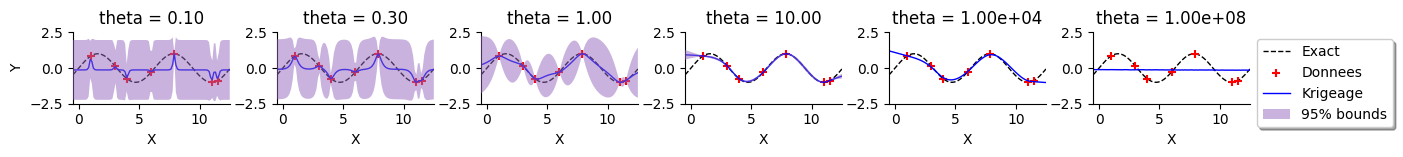

In [5]:
ymax = 2.5
ymin = -ymax
bounding_box = ot.Interval([xmin, ymin], [xmax, ymax])
dimension = 1
theta_parameter_list = [0.1, 0.3, 1.0, 10.0, 1.0e4, 1.0e8]
grid = ot.GridLayout(1, len(theta_parameter_list))
for i in range(len(theta_parameter_list)):
    theta_parameter = theta_parameter_list[i]
    graph = plot_kriging_metamodel(
        dimension, theta_parameter, x_test, y_test, x_train, y_train
    )
    if i > 0:
        graph.setYTitle("")
    if i < len(theta_parameter_list) - 1:
        graph.setLegends([""])
    graph.setBoundingBox(bounding_box)
    grid.setGraph(0, i, graph)
_ = otv.View(
    grid,
    figure_kw={"figsize": (14.0, 2.0)},
    legend_kw={"bbox_to_anchor": (1.0, 1.0), "loc": "upper left"},
)
pl.subplots_adjust(wspace=0.3)

On observe que si $\theta \rightarrow 0$, alors l'incertitude est maximale entre deux points d'interpolation. Le modèle reste toutefois interpolant. Cependant un voisinage même très proche d'un point d'interpolation est associée à une incertitude correspondant à un interval de confiance bilatéral d'une distribution gaussienne $\mathcal{N}(0, 1)$ au niveau 95%, c'est-à-dire $[-1.95, 1.95]$.  

In [6]:
alpha = 0.05
normal_distribution = ot.Normal(0.0, 1.0)
bilateralCI = normal_distribution.computeBilateralConfidenceInterval(1.0 - alpha)
bilateralCI

class=Interval name=Unnamed dimension=1 lower bound=class=Point name=Unnamed dimension=1 values=[-1.95996] upper bound=class=Point name=Unnamed dimension=1 values=[1.95996] finite lower bound=[1] finite upper bound=[1]

## Analyse du krigeage en fonction de la longueur de corrélation

On considère le modèle exponentiel carré isotrope en dimension $d = 1$. 
Pour définir la covariance du processus gaussien, on fait le choix d'une fonction de corrélation $r$ de la forme :
$$
k\left(x, x'\right) = \sigma^2 r\left(x - x', \theta\right)
$$
où $\sigma^2$ est la variance du processus gaussien et $\boldsymbol{\theta} \in\mathbb{R}^p$. Le modèle exponentiel carré anisotrope est la fonction de covariance définie par :
$$
r\left(x, x' \right) 
= \exp\left( -\frac{1}{2} \frac{(x - x')^2}{\theta^2}\right)
$$
pour tout $x, x' \in \mathcal{D} \subset \mathbb{R}$ où $\sigma\in\mathbb{R}$ est le paramètre d'amplitude et $\boldsymbol{\theta}\in\mathbb{R}$ est le paramètre d'échelle.

Notons $F = \boldsymbol{1}_{n \times 1}$ la matrice de conception associée aux fonctions de base constantes. Notons $R$ la matrice de correlation associée au noyau de corrélation :
$$
R = \left[ r\left(x^{(i)}, x^{(j)},\boldsymbol{\theta}\right),\quad i,j = 1, ..., n \right].
$$

Considérons un nouveau point $x \in \mathcal{D}$ correspondant à une sortie $y$ inconnue.
Le vecteur aléatoire associé aux observations $\boldsymbol{Y}$ et la variable aléatoire $Y(x)$ sont liés par une loi normale :

$$
\begin{pmatrix}
\boldsymbol{Y} \\
Y(x)
\end{pmatrix}
= 
\mathcal{N}
\left(
\begin{pmatrix}
F \beta \\
\beta
\end{pmatrix}
, \; 
\sigma^2 
\begin{pmatrix}
R & \boldsymbol{r}(x) \\
\boldsymbol{r}(x)^T & 1 \\
\end{pmatrix}
\right).
$$

Supposons que $x \neq x'$. Analysons le modèle lorsque $\theta \rightarrow +\infty$ et lorsque $\theta \rightarrow 0$. 
- Si $\theta \rightarrow +\infty$ alors $-\frac{1}{2} \frac{(x - x')^2}{\theta^2} \rightarrow 0$ ce qui implique $r\left(x, x' \right) \rightarrow \exp(0) = 1$ et $k\left(x, x' \right) \rightarrow \sigma^2 \exp(0) = \sigma^2$. Dans ce cas, on a :
$$
\begin{pmatrix}
\boldsymbol{Y} \\
Y(x)
\end{pmatrix}
= 
\mathcal{N}
\left(
\begin{pmatrix}
F \beta \\
\beta
\end{pmatrix}
, \; 
\sigma^2 
\begin{pmatrix}
\boldsymbol{1}_{n \times n} & \boldsymbol{1}_{n \times 1} \\
\boldsymbol{1}_{1 \times n} & 1 \\
\end{pmatrix}
\right)
$$

où $\beta \in \mathbb{R}$ est la moyenne associée à la tendance constante.

- Si $\theta \rightarrow 0$ alors $-\frac{1}{2} \frac{(x - x')^2}{\theta^2} \rightarrow -\infty$ ce qui implique $r\left(x, x' \right) \rightarrow \exp(-\infty) = 0$ et $k\left(x, x' \right) \rightarrow \sigma^2 \times 0 = 0$.
Dans ce cas, on a :
$$
\begin{pmatrix}
\boldsymbol{Y} \\
Y(x)
\end{pmatrix}
= 
\mathcal{N}
\left(
\begin{pmatrix}
F \beta \\
\beta
\end{pmatrix}
, \; 
\boldsymbol{0}_{(n + 1) \times (n + 1)}
\right)
$$
